In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
os.chdir('/content/drive/MyDrive/LivestockDetection2025')

In [ ]:
!ls

COCO_Format	       models		 yolo11n.pt    yolo12s.pt
cow_detection_results  my_dataset	 yolo12l.onnx  yolo12x.onnx
dataset_tf_2025        predicted_images  yolo12l.pt    yolo12x.pt
data.yaml	       retinanet	 yolo12m.onnx  yolov5
DETR-Livestock	       runs		 yolo12m.pt    yolov8x.onnx
DJI_0486.MP4	       SSD_Training	 yolo12n.onnx  yolov8x.pt
DJI_0618.MP4	       testing_images	 yolo12n.pt
labels.txt	       ultralytics	 yolo12s.onnx


In [ ]:
import torch
import torchvision
from torch.utils.data import DataLoader
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.datasets import CocoDetection
from torchvision.transforms import functional as F
import matplotlib.pyplot as plt
from PIL import Image

In [ ]:
# Define transformations
class CocoTransform:
    def __call__(self, image, target):
        image = F.to_tensor(image)  # Convert PIL image to tensor
        return image, target

In [ ]:
# Dataset class
def get_coco_dataset(img_dir, ann_file):
    return CocoDetection(
        root=img_dir,
        annFile=ann_file,
        transforms=CocoTransform()
    )

# Load datasets
train_dataset = get_coco_dataset(
    img_dir="/content/drive/MyDrive/LivestockDetection2025/dataset_tf_2025/train/images",
    ann_file="/content/drive/MyDrive/LivestockDetection2025/dataset_tf_2025/train/images/annotations_coco.json"
)


val_dataset = get_coco_dataset(
    img_dir="/content/drive/MyDrive/LivestockDetection2025/dataset_tf_2025/test/images",
    ann_file="/content/drive/MyDrive/LivestockDetection2025/dataset_tf_2025/test/images/annotations_coco.json"
)

val_dataset = get_coco_dataset(
    img_dir="/content/drive/MyDrive/LivestockDetection2025/dataset_tf_2025/val/images",
    ann_file="/content/drive/MyDrive/LivestockDetection2025/dataset_tf_2025/val/images/annotations_coco.json"
)

# DataLoader
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, collate_fn=lambda x: tuple(zip(*x)))
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False, collate_fn=lambda x: tuple(zip(*x)))

loading annotations into memory...
Done (t=0.37s)
creating index...
index created!
loading annotations into memory...
Done (t=0.45s)
creating index...
index created!
loading annotations into memory...
Done (t=0.61s)
creating index...
index created!


In [ ]:
# Load Faster R-CNN with ResNet-50 backbone
def get_model(num_classes):
    # Load pre-trained Faster R-CNN
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

    # Get the number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features

    # Replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    return model

In [ ]:
# Initialize the model
num_classes = 2 # Background + cow
model = get_model(num_classes)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|██████████| 160M/160M [00:00<00:00, 184MB/s]


In [ ]:
# Move model to GPU if available
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

# Define optimizer and learning rate scheduler
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.001, momentum=0.9, weight_decay=0.0005)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

In [ ]:
def train_one_epoch(model, optimizer, data_loader, device, epoch):
    model.train()
    for images, targets in data_loader:
        # Move images to the device
        images = [img.to(device) for img in images]

        # Validate and process targets
        processed_targets = []
        valid_images = []
        for i, target in enumerate(targets):
            boxes = []
            labels = []
            for obj in target:
                # Extract bbox
                bbox = obj["bbox"]  # Format: [x, y, width, height]
                x, y, w, h = bbox

                # Ensure the width and height are positive
                if w > 0 and h > 0:
                    boxes.append([x, y, x + w, y + h])  # Convert to [x_min, y_min, x_max, y_max]
                    labels.append(obj["category_id"])

            # Only process if there are valid boxes
            if boxes:
                processed_target = {
                    "boxes": torch.tensor(boxes, dtype=torch.float32).to(device),
                    "labels": torch.tensor(labels, dtype=torch.int64).to(device),
                }
                processed_targets.append(processed_target)
                valid_images.append(images[i])  # Add only valid images

                # Skip iteration if no valid targets
        if not processed_targets:
            continue

        # Ensure images and targets are aligned
        images = valid_images

        # Forward pass
        loss_dict = model(images, processed_targets)
        losses = sum(loss for loss in loss_dict.values())

        # Backpropagation
        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

    print(f"Epoch [{epoch}] Loss: {losses.item():.4f}")

In [ ]:
# Training loop
num_epochs = 100
for epoch in range(num_epochs):
    train_one_epoch(model, optimizer, train_loader, device, epoch)
    lr_scheduler.step()

    # Save the model's state dictionary after every epoch
    model_path = f"fasterrcnn_resnet50_epoch_{epoch + 1}.pth"
    torch.save(model.state_dict(), model_path)
    print(f"Model saved: {model_path}")

Epoch [0] Loss: 0.5863
Model saved: fasterrcnn_resnet50_epoch_1.pth
Epoch [1] Loss: 0.4965
Model saved: fasterrcnn_resnet50_epoch_2.pth
Epoch [2] Loss: 0.4768
Model saved: fasterrcnn_resnet50_epoch_3.pth
Epoch [3] Loss: 0.3920
Model saved: fasterrcnn_resnet50_epoch_4.pth
Epoch [4] Loss: 0.7341
Model saved: fasterrcnn_resnet50_epoch_5.pth
Epoch [5] Loss: 0.3752
Model saved: fasterrcnn_resnet50_epoch_6.pth
Epoch [6] Loss: 0.3629
Model saved: fasterrcnn_resnet50_epoch_7.pth
Epoch [7] Loss: 0.3285
Model saved: fasterrcnn_resnet50_epoch_8.pth
Epoch [8] Loss: 0.4627
Model saved: fasterrcnn_resnet50_epoch_9.pth
Epoch [9] Loss: 0.3952
Model saved: fasterrcnn_resnet50_epoch_10.pth
Epoch [10] Loss: 0.4667
Model saved: fasterrcnn_resnet50_epoch_11.pth
Epoch [11] Loss: 0.2964
Model saved: fasterrcnn_resnet50_epoch_12.pth
Epoch [12] Loss: 0.2904
Model saved: fasterrcnn_resnet50_epoch_13.pth
Epoch [13] Loss: 0.4402
Model saved: fasterrcnn_resnet50_epoch_14.pth
Epoch [14] Loss: 0.3353
Model saved: fa

In [ ]:
!pip install torchmetrics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.9/981.9 kB 18.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 129.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 99.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 50.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 11.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 42.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 19.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 111.6 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Unins

In [ ]:
from torchmetrics.detection.mean_ap import MeanAveragePrecision
import matplotlib.pyplot as plt
from torchsummary import summary

In [ ]:
# Print model summary
model.eval() # Set model to evaluation mode
print(model)

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

In [ ]:
metric = MeanAveragePrecision()

In [ ]:
model.eval()
all_preds = []
all_targets = []

with torch.no_grad():
    for images, targets in val_loader:
        images = list(img.to(device) for img in images)
        outputs = model(images)

        # Convert outputs and targets to expected format for torchmetrics
        preds = []
        targs = []
        for o, t_list in zip(outputs, targets): # t_list is a list of dictionaries for one image
            # Process predictions
            preds.append({
                'boxes': o['boxes'].cpu(),
                'scores': o['scores'].cpu(),
                'labels': o['labels'].cpu(),
            })

            # Process ground truth targets
            boxes = []
            labels = []
            for t in t_list: # Iterate through the list of dictionaries for the current image
                 # Ensure the width and height are positive before converting to [x_min, y_min, x_max, y_max]
                bbox = t["bbox"]
                x, y, w, h = bbox
                if w > 0 and h > 0:
                    boxes.append([x, y, x + w, y + h])
                    labels.append(t["category_id"])

            targs.append({
                'boxes': torch.tensor(boxes, dtype=torch.float32),
                'labels': torch.tensor(labels, dtype=torch.int64),
            })

        metric.update(preds, targs)

# Compute final metrics
results = metric.compute()
print("Evaluation Metrics:")
for k, v in results.items():
    print(f"{k}: {v}")

Evaluation Metrics:
map: 0.6322290897369385
map_50: 0.9441969394683838
map_75: 0.7312706708908081
map_small: -1.0
map_medium: 0.40090060234069824
map_large: 0.6538797616958618
mar_1: 0.122023805975914
mar_10: 0.6107142567634583
mar_100: 0.6875
mar_small: -1.0
mar_medium: 0.4928571283817291
mar_large: 0.7051948308944702
map_per_class: -1.0
mar_100_per_class: -1.0
classes: 1


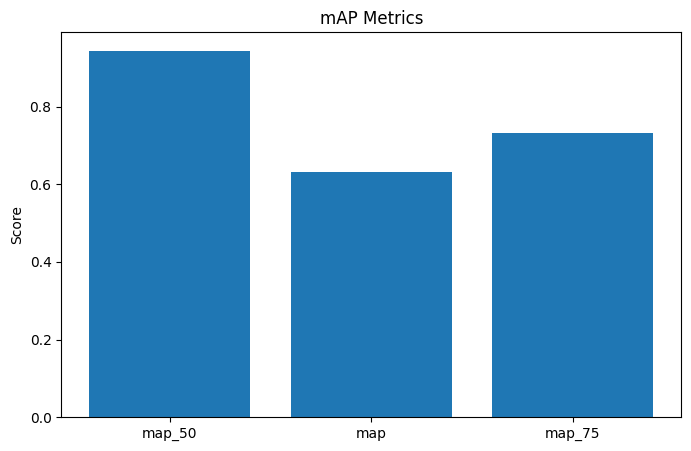

In [ ]:
# Visualize metrics
metrics_to_plot = ['map_50', 'map', 'map_75']
values = [results[m] for m in metrics_to_plot]

plt.figure(figsize=(8,5))
plt.bar(metrics_to_plot, values)
plt.title('mAP Metrics')
plt.ylabel('Score')
plt.show()

In [ ]:
# Re-initialize the model
num_classes = 2 # Background + cow
model = get_model(num_classes)

# Move model to GPU if available
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

# Load the trained weights
# Assuming the last saved epoch was 100, you can change the filename if needed
model_path = "/content/drive/MyDrive/LivestockDetection2025/fasterrcnn_resnet50_epoch_99.pth"
model.load_state_dict(torch.load(model_path, map_location=device))

# Set the model to evaluation mode
model.eval()

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

In [ ]:
print("Object Detection Metrics:")
print(f"mAP@50: {results['map_50'].item():.4f}")
print(f"mAP@50-95: {results['map'].item():.4f}")

# Note: MeanAveragePrecision in torchmetrics primarily focuses on mAP variants.
# Overall precision, recall, and F1-score across the entire dataset are not
# directly provided as single values by this metric in the same way as
# classification metrics. The 'mar_1', 'mar_10', and 'mar_100' in the results
# relate to Mean Average Recall.
# If you need to calculate precision, recall, and F1-score specifically,
# it would require a different evaluation approach that iterates through
# predictions and ground truths to compute True Positives, False Positives,
# and False Negatives based on IoU thresholds.

Object Detection Metrics:
mAP@50: 0.9442
mAP@50-95: 0.6322


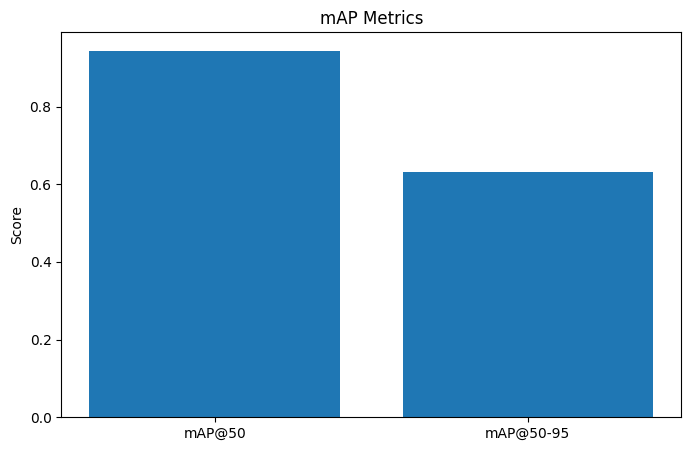

In [ ]:
# Visualize metrics
metrics_to_plot = ['map_50', 'map']
values = [results[m].item() for m in metrics_to_plot] # Use .item() to get scalar value for plotting

plt.figure(figsize=(8,5))
plt.bar(metrics_to_plot, values)
plt.title('mAP Metrics')
plt.ylabel('Score')
plt.xticks(ticks=[0, 1], labels=['mAP@50', 'mAP@50-95']) # Set custom labels for clarity
plt.show()

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


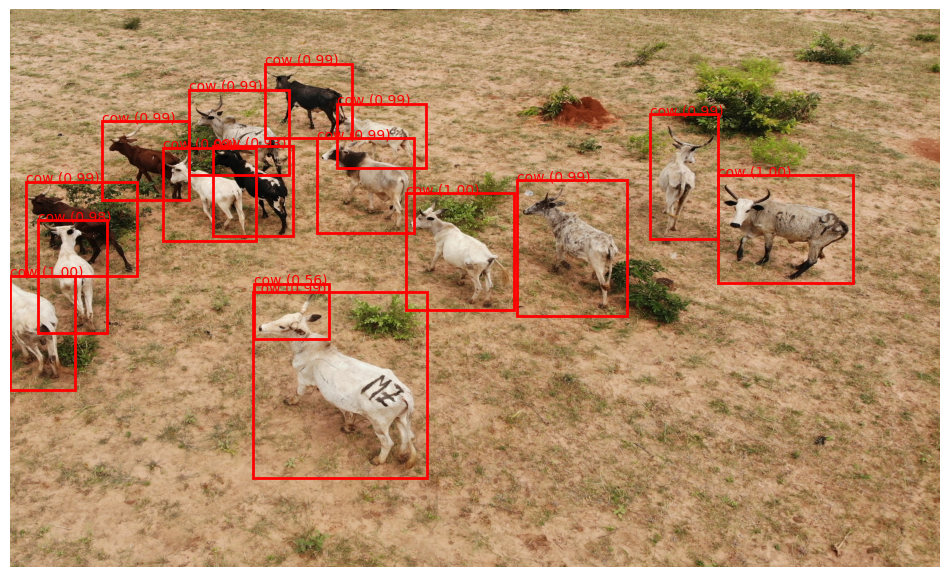

In [ ]:
import torch
import torchvision
from torch.utils.data import DataLoader
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.datasets import CocoDetection
from torchvision.transforms import functional as F
import matplotlib.pyplot as plt
from PIL import Image

# Load Faster R-CNN with ResNet-50 backbone
def get_model(num_classes):
    # Load pre-trained Faster R-CNN
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
    # Get the number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # Replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    return model


# Initialize the model
num_classes = 2  # Background + cow

# Move model to GPU if available
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')


# Load the trained model
model = get_model(num_classes)
model.load_state_dict(torch.load("/content/drive/MyDrive/LivestockDetection2025/Faster-RCNN_checkpoint/fasterrcnn_resnet50_epoch_99.pth"))
model.to(device)
model.eval()  # Set the model to evaluation mode

def prepare_image(image_path):
    image = Image.open(image_path).convert("RGB")  # Open image
    image_tensor = F.to_tensor(image).unsqueeze(0)  # Convert image to tensor and add batch dimension
    return image_tensor.to(device)



# Load the unseen image
image_path = "/content/drive/MyDrive/LivestockDetection2025/dataset_tf_2025/test/images/N4.JPG"
image_tensor = prepare_image(image_path)

with torch.no_grad():  # Disable gradient computation for inference
    prediction = model(image_tensor)

# `prediction` contains:
# - boxes: predicted bounding boxes
# - labels: predicted class labels
# - scores: predicted scores for each box (confidence level)
COCO_CLASSES = {0: "Background", 1: "cow"}

def get_class_name(class_id):
    return COCO_CLASSES.get(class_id, "Unknown")

# Draw bounding boxes with the correct class names and increase image size
def draw_boxes(image, prediction, fig_size=(10, 10)):
    boxes = prediction[0]['boxes'].cpu().numpy()  # Get predicted bounding boxes
    labels = prediction[0]['labels'].cpu().numpy()  # Get predicted labels
    scores = prediction[0]['scores'].cpu().numpy()  # Get predicted scores

    # Set a threshold for showing boxes (e.g., score > 0.5)
    threshold = 0.5

    # Set up the figure size to c
     # Set up the figure size to control the image size
    plt.figure(figsize=fig_size)  # Adjust the figure size here

    for box, label, score in zip(boxes, labels, scores):
        if score > threshold:
            x_min, y_min, x_max, y_max = box
            class_name = get_class_name(label)  # Get the class name
            plt.imshow(image)  # Display the image
            plt.gca().add_patch(plt.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min,
                                              linewidth=2, edgecolor='r', facecolor='none'))
            plt.text(x_min, y_min, f"{class_name} ({score:.2f})", color='r')

    plt.axis('off')  # Turn off axis
    plt.show()

# Display the image with bounding boxes and correct labels
draw_boxes(Image.open(image_path), prediction, fig_size=(12, 10))  # Example of increased size

In [ ]:
import torch
import torchvision
from torch.utils.data import DataLoader
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.datasets import CocoDetection
from torchvision.transforms import functional as F
import matplotlib.pyplot as plt
from PIL import Image

# Load Faster R-CNN with ResNet-50 backbone
def get_model(num_classes):
    # Load pre-trained Faster R-CNN
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
    # Get the number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # Replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    return model


# Initialize the model
num_classes = 2  # Background + cow

# Move model to GPU if available
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')


# Load the trained model
model = get_model(num_classes)
model.load_state_dict(torch.load("/content/drive/MyDrive/LivestockDetection2025/fasterrcnn_resnet50_epoch_99.pth"))
model.to(device)
model.eval()  # Set the model to evaluation mode

def prepare_image(image_path):
    image = Image.open(image_path).convert("RGB")  # Open image
    image_tensor = F.to_tensor(image).unsqueeze(0)  # Convert image to tensor and add batch dimension
    return image_tensor.to(device)



# Load the unseen image
image_path = "/content/drive/MyDrive/LivestockDetection2025/dataset_tf_2025/test/images/N4.JPG"
image_tensor = prepare_image(image_path)

with torch.no_grad():  # Disable gradient computation for inference
    prediction = model(image_tensor)

# `prediction` contains:
# - boxes: predicted bounding boxes
# - labels: predicted class labels
# - scores: predicted scores for each box (confidence level)
COCO_CLASSES = {0: "Background", 1: "cow"}

def get_class_name(class_id):
    return COCO_CLASSES.get(class_id, "Unknown")

# Draw bounding boxes with the correct class names and increase image size
def draw_boxes(image, prediction, fig_size=(10, 10)):
    boxes = prediction[0]['boxes'].cpu().numpy()  # Get predicted bounding boxes
    labels = prediction[0]['labels'].cpu().numpy()  # Get predicted labels
    scores = prediction[0]['scores'].cpu().numpy()  # Get predicted scores

    # Set a threshold for showing boxes (e.g., score > 0.5)
    threshold = 0.5

    # Set up the figure size to c
     # Set up the figure size to control the image size
    plt.figure(figsize=fig_size)  # Adjust the figure size here

    for box, label, score in zip(boxes, labels, scores):
        if score > threshold:
            x_min, y_min, x_max, y_max = box
            class_name = get_class_name(label)  # Get the class name
            plt.imshow(image)  # Display the image
            plt.gca().add_patch(plt.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min,
                                              linewidth=2, edgecolor='r', facecolor='none'))
            plt.text(x_min, y_min, f"{class_name} ({score:.2f})", color='r')

    plt.axis('off')  # Turn off axis
    plt.show()

# Display the image with bounding boxes and correct labels
draw_boxes(Image.open(image_path), prediction, fig_size=(12, 10))  # Example of increased size

After running this cell, you can re-run the evaluation cell (`cell_id: ySbfpZ2L8LXF`) to compute the metrics.

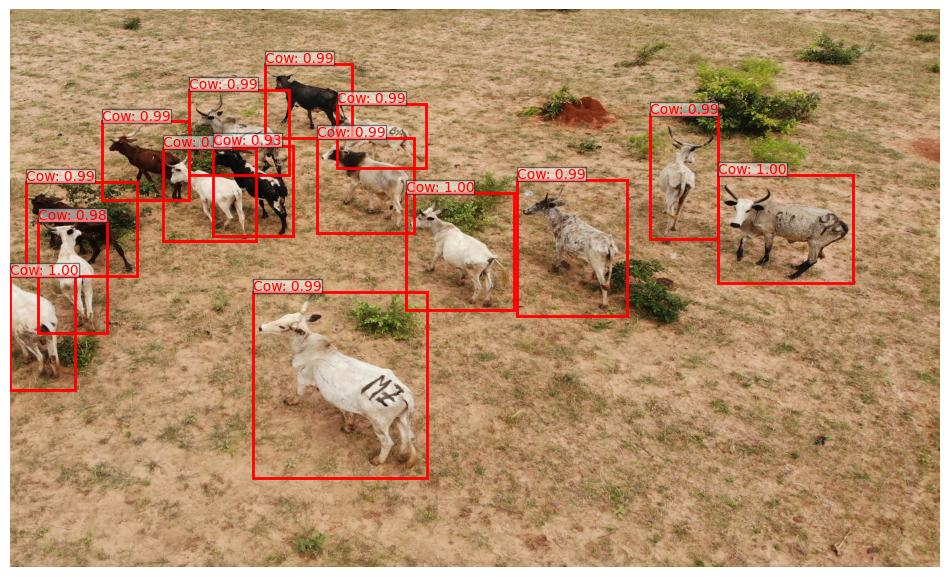

In [ ]:
import torch
import torchvision
from torch.utils.data import DataLoader
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.datasets import CocoDetection
from torchvision.transforms import functional as F
import matplotlib.pyplot as plt
from PIL import Image

# Load Faster R-CNN with ResNet-50 backbone
def get_model(num_classes):
    # Load pre-trained Faster R-CNN
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
    # Get the number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # Replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    return model


# Initialize the model
num_classes = 2 # Background + cow

# Move model to GPU if available
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')


# Load the trained model
model = get_model(num_classes)
model_path = "/content/drive/MyDrive/LivestockDetection2025/Faster-RCNN_checkpoint/fasterrcnn_resnet50_epoch_99.pth" # Assuming epoch 100 was the last saved, change if needed
model.load_state_dict(torch.load(model_path, map_location=device))
model.to(device)
model.eval()  # Set the model to evaluation mode

def prepare_image(image_path):
    image = Image.open(image_path).convert("RGB")  # Open image
    image_tensor = F.to_tensor(image).unsqueeze(0)  # Convert image to tensor and add batch dimension
    return image_tensor.to(device)


# **IMPORTANT:** Replace "test_image.jpg" with the actual path to your test image.
# Make sure this image is accessible in your Colab environment (e.g., in your Google Drive).
image_path = "/content/drive/MyDrive/LivestockDetection2025/dataset_tf_2025/test/images/N4.JPG" # Example path, change as needed
image_tensor = prepare_image(image_path)

with torch.no_grad():  # Disable gradient computation for inference
    prediction = model(image_tensor)

# `prediction` contains:
# - boxes: predicted bounding boxes
# - labels: predicted class labels
# - scores: predicted scores for each box (confidence level)

# Define a mapping from class ID to class name
# Update this dictionary based on your dataset's class IDs and names
COCO_CLASSES = {0: "Background", 1: "Cow"} # Example, update with your actual classes

def get_class_name(class_id):
    return COCO_CLASSES.get(class_id, "Unknown")

# Draw bounding boxes with class names and scores
def draw_boxes(image, prediction, fig_size=(12, 10)):
    boxes = prediction[0]['boxes'].cpu().numpy()  # Get predicted bounding boxes
    labels = prediction[0]['labels'].cpu().numpy()  # Get predicted labels
    scores = prediction[0]['scores'].cpu().numpy()  # Get predicted scores

    # Set a threshold for showing boxes (e.g., score > 0.5)
    threshold = 0.7 # You can adjust this threshold

    # Set up the figure size to control the image size
    plt.figure(figsize=fig_size)  # Adjust the figure size here

    # Display the image
    plt.imshow(image)

    ax = plt.gca() # Get current axes

    for box, label, score in zip(boxes, labels, scores):
        if score > threshold:
            x_min, y_min, x_max, y_max = box
            class_name = get_class_name(label)  # Get the class name

            # Draw the rectangle
            rect = plt.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min,
                                 linewidth=2, edgecolor='r', facecolor='none')
            ax.add_patch(rect)

            # Add the text label
            plt.text(x_min, y_min - 5, f"{class_name}: {score:.2f}", color='r', fontsize=10,
                     bbox=dict(facecolor='white', alpha=0.5, pad=0))

    plt.axis('off')  # Turn off axis
    plt.show()

# Load the image for visualization
# Make sure to use the correct path to your test image
test_image_path = "/content/drive/MyDrive/LivestockDetection2025/dataset_tf_2025/test/images/N4.JPG" # Use the same path as above
test_image = Image.open(test_image_path).convert("RGB")

# Display the image with bounding boxes and correct labels
draw_boxes(test_image, prediction, fig_size=(12, 10)) # Adjust fig_size as needed for display

In [ ]:
import time

with torch.no_grad():  # Disable gradient computation for inference
    start_time = time.time()  # Start timer

    prediction = model(image_tensor)  # Run inference

    end_time = time.time()  # End timer
    inference_time = end_time - start_time
    print(f"Inference time per image: {inference_time:.4f} seconds")


Inference time per image: 0.0307 seconds


In [ ]:
import time

# Prepare the image
image_path = "/content/drive/MyDrive/LivestockDetection2025/dataset_tf_2025/test/images/N4.JPG"
image_tensor = prepare_image(image_path)

# Run inference with timing
with torch.no_grad():
    start_time = time.time()
    prediction = model(image_tensor)
    end_time = time.time()

# Print inference time
inference_time = end_time - start_time
print(f"Inference time per image: {inference_time:.4f} seconds")


Inference time per image: 0.0270 seconds


In [ ]:
import time

# Prepare the image
image_path = "/content/drive/MyDrive/LivestockDetection2025/dataset_tf_2025/test/images/N4.JPG"
image_tensor = prepare_image(image_path)

# Run inference with timing
with torch.no_grad():
    start_time = time.time()
    prediction = model(image_tensor)
    end_time = time.time()

# Convert seconds to milliseconds
inference_time_ms = (end_time - start_time) * 1000
print(f"Inference time per image: {inference_time_ms:.2f} ms")


Inference time per image: 28.06 ms


In [ ]:
import torch
from torchvision.ops import box_iou

def calculate_precision_recall_f1(predictions, targets, device, iou_threshold=0.5, conf_threshold=0.5):
    """
    Calculates precision, recall, and F1-score for object detection predictions.

    Args:
        predictions (list): A list of dictionaries, where each dictionary
                            contains 'boxes', 'scores', and 'labels' for one image.
        targets (list): A list of dictionaries, where each dictionary
                        contains 'boxes' and 'labels' for one image.
        device (torch.device): The device to perform calculations on.
        iou_threshold (float): The IoU threshold for considering a prediction as a True Positive.
        conf_threshold (float): The confidence threshold for considering a prediction.

    Returns:
        tuple: A tuple containing overall precision, recall, and F1-score.
    """
    total_true_positives = 0
    total_false_positives = 0
    total_false_negatives = 0

    for img_predictions, img_targets in zip(predictions, targets):
        # Move predicted boxes to the correct device
        pred_boxes = img_predictions['boxes'].to(device)
        pred_scores = img_predictions['scores'].to(device)
        pred_labels = img_predictions['labels'].to(device)
        # Move target boxes to the correct device
        target_boxes = img_targets['boxes'].to(device)
        target_labels = img_targets['labels'].to(device)


        # Filter predictions by confidence threshold
        confident_preds_indices = pred_scores >= conf_threshold
        pred_boxes = pred_boxes[confident_preds_indices]
        pred_labels = pred_labels[confident_preds_indices]

        if pred_boxes.numel() == 0 and target_boxes.numel() == 0:
            continue # No predictions and no targets, skip

        if pred_boxes.numel() == 0 and target_boxes.numel() > 0:
            total_false_negatives += target_boxes.shape[0]
            continue # No predictions but there are targets

        if pred_boxes.numel() > 0 and target_boxes.numel() == 0:
             total_false_positives += pred_boxes.shape[0]
             continue # Predictions but no targets

        # Calculate IoU between predictions and targets
        iou_matrix = box_iou(pred_boxes, target_boxes)

        # Match predictions to ground truth
        # For simplicity, a prediction is matched to the target with the highest IoU > iou_threshold
        # and matching labels. Each ground truth box can only be matched once.
        matched_preds = torch.zeros(pred_boxes.shape[0], dtype=torch.bool, device=device)
        matched_targets = torch.zeros(target_boxes.shape[0], dtype=torch.bool, device=device)
        true_positives = 0

        # Iterate through predictions to find matches
        for i in range(pred_boxes.shape[0]):
            best_iou = 0
            best_target_idx = -1
            for j in range(target_boxes.shape[0]):
                if not matched_targets[j] and pred_labels[i] == target_labels[j]:
                    if iou_matrix[i, j] > best_iou:
                        best_iou = iou_matrix[i, j]
                        best_target_idx = j

            if best_iou >= iou_threshold and best_target_idx != -1:
                true_positives += 1
                matched_preds[i] = True
                matched_targets[best_target_idx] = True

        false_positives = (~matched_preds).sum().item()
        false_negatives = (~matched_targets).sum().item()

        total_true_positives += true_positives
        total_false_positives += false_positives
        total_false_negatives += false_negatives

    # Calculate precision, recall, and F1-score
    precision = total_true_positives / (total_true_positives + total_false_positives) if (total_true_positives + total_false_positives) > 0 else 0
    recall = total_true_positives / (total_true_positives + total_false_negatives) if (total_true_positives + total_false_negatives) > 0 else 0
    f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

    return precision, recall, f1_score

# --- Evaluation Loop to get predictions and targets ---
model.eval()
all_predictions = []
all_ground_truths = []

with torch.no_grad():
    for images, targets in val_loader:
        images = list(img.to(device) for img in images)
        outputs = model(images)

        # Append predictions and ground truths (keep on device for calculation)
        all_predictions.extend(outputs)

        # Process targets to match the format expected by the calculation function
        processed_targets = []
        for t_list in targets: # t_list is a list of dictionaries for one image
             boxes = []
             labels = []
             for t in t_list: # Iterate through the list of dictionaries for the current image
                  bbox = t["bbox"]
                  x, y, w, h = bbox
                  if w > 0 and h > 0:
                      boxes.append([x, y, x + w, y + h])
                      labels.append(t["category_id"])

             # Convert target boxes and labels to tensors and move to the correct device
             processed_targets.append({
                 'boxes': torch.tensor(boxes, dtype=torch.float32).to(device),
                 'labels': torch.tensor(labels, dtype=torch.int64).to(device),
             })
        all_ground_truths.extend(processed_targets)


# --- Calculate and Print Metrics ---
# Pass the device to the calculation function
precision, recall, f1_score = calculate_precision_recall_f1(all_predictions, all_ground_truths, device, iou_threshold=0.5, conf_threshold=0.5)

print("\nCalculated Metrics (IoU=0.5, Confidence=0.5):")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1_score:.4f}")

# Note: These metrics are calculated at a specific IoU and confidence threshold
# and represent overall performance, not class-specific metrics or a full PR curve.


Calculated Metrics (IoU=0.5, Confidence=0.5):
Precision: 0.8360
Recall: 0.9405
F1-score: 0.8852


In [ ]:
# Visualize metrics
metrics_to_plot = ['Precision', 'Recall', 'F1-score']
values = [results[m] for m in metrics_to_plot]

plt.figure(figsize=(8,5))
plt.bar(metrics_to_plot, values)
plt.title('Metrics for Object Detection')

plt.ylabel('Score')
plt.show()

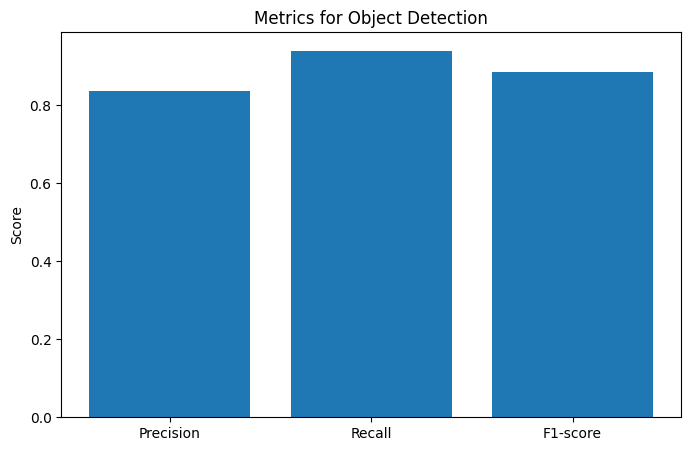

In [ ]:
# Visualize metrics
metrics_to_plot = ['Precision', 'Recall', 'F1-score']
values = [precision, recall, f1_score]

plt.figure(figsize=(8,5))
plt.bar(metrics_to_plot, values)
plt.title('Metrics for Object Detection')

plt.ylabel('Score')
plt.show()

In [ ]:
!pip install ptflops

In [ ]:
!pip install torchinfo

In [ ]:
from torchinfo import summary
from torchvision.models.detection import fasterrcnn_resnet50_fpn

model = fasterrcnn_resnet50_fpn(pretrained=True)
summary(model, input_size=(1, 3, 800, 1333))


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Layer (type:depth-idx)                                  Output Shape              Param #
FasterRCNN                                              [0, 4]                    --
├─GeneralizedRCNNTransform: 1-1                         [1, 3, 800, 1344]         --
├─BackboneWithFPN: 1-2                                  [1, 256, 13, 21]          --
│    └─IntermediateLayerGetter: 2-1                     [1, 2048, 25, 42]         --
│    │    └─Conv2d: 3-1                                 [1, 64, 400, 672]         (9,408)
│    │    └─FrozenBatchNorm2d: 3-2                      [1, 64, 400, 672]         --
│    │    └─ReLU: 3-3                                   [1, 64, 400, 672]         --
│    │    └─MaxPool2d: 3-4                              [1, 64, 200, 336]         --
│    │    └─Sequential: 3-5                             [1, 256, 200, 336]        (212,992)
│    │    └─Sequential: 3-6                             [1, 512, 100, 168]        1,212,416
│    │    └─Sequential: 3-7              

In [ ]:
from ptflops import get_model_complexity_info

flops, params = get_model_complexity_info(model, (3, 800, 1333), as_strings=True)
print('FLOPs:', flops)
print('Parameters:', params)

FasterRCNN(
  41.53 M, 100.000% Params, 216.31 GMac, 99.873% MACs, 
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    26.58 M, 63.990% Params, 148.75 GMac, 68.681% MACs, 
    (body): IntermediateLayerGetter(
      23.23 M, 55.938% Params, 87.8 GMac, 40.541% MACs, 
      (conv1): Conv2d(0, 0.000% Params, 2.53 GMac, 1.168% MACs, 3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(0, 0.000% Params, 17.2 MMac, 0.008% MACs, inplace=True)
      (maxpool): MaxPool2d(0, 0.000% Params, 17.2 MMac, 0.008% MACs, kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        0, 0.000% Params, 14.39 GMac, 6.644% MACs, 
        (0): Bottleneck(
          0, 0.000% Params, 4.98 GMac, 2.300% MACs, 
          (conv1): Conv2d(0